# 💡 What's new in txtai 4.0

txtai 4.0 brings a number of major feature enhancements, most importantly the capability to store full document content and text right in txtai. This notebook will cover all the changes with examples.

# Install dependencies

Install `txtai` and all dependencies.

In [23]:
%%capture
!pip install git+https://github.com/neuml/txtai

# Content storage
Up to now with txtai, once text was vectorized, it was no longer possible to trace back to the input text. Only document ids and vectors were stored. Results consisted of ids and scores. It was the responsibility of the developer to resolve matches with an external data store. 

txtai 4.0 brings a major paradigm shift. Content can now be stored alongside embeddings vectors. This opens up a number of exciting possibilities with txtai!

Let's see with the classic txtai example below.

In [24]:
from txtai.embeddings import Embeddings

data = ["US tops 5 million confirmed virus cases",
        "Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg",
        "Beijing mobilises invasion craft along coast as Taiwan tensions escalate",
        "The National Park Service warns against sacrificing slower friends in a bear attack",
        "Maine man wins $1M from $25 lottery ticket",
        "Make huge profits without work, earn up to $100,000 a day"]

# Create embeddings index with content enabled. The default behavior is to only store indexed vectors.
embeddings = Embeddings({"path": "sentence-transformers/nli-mpnet-base-v2", "content": True, "objects": True})

# Create an index for the list of text
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

# Run an embeddings search for each query
for query in ("feel good story", "climate change", "public health story", "war", "wildlife", "asia", "lucky", "dishonest junk"):
    # Extract text field from result
    text = embeddings.search(query, 1)[0]["text"]

    # Print text
    print("%-20s %s" % (query, text))

Query                Best Match
--------------------------------------------------
feel good story      Maine man wins $1M from $25 lottery ticket
climate change       Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg
public health story  US tops 5 million confirmed virus cases
war                  Beijing mobilises invasion craft along coast as Taiwan tensions escalate
wildlife             The National Park Service warns against sacrificing slower friends in a bear attack
asia                 Beijing mobilises invasion craft along coast as Taiwan tensions escalate
lucky                Maine man wins $1M from $25 lottery ticket
dishonest junk       Make huge profits without work, earn up to $100,000 a day


The only change above is setting the *content* flag to True. This enables storing text and metadata content (if provided) alongside the index. Note how the text is pulled right from the query result!

# Query with SQL

When content is enabled, the entire dictionary will be stored and can be queried. In addition to similarity queries, txtai accepts SQL queries. This enables combined queries using both a similarity index and content stored in a database backend.

In [25]:
# Create an index for the list of text
embeddings.index([(uid, {"text": text, "length": len(text)}, None) for uid, text in enumerate(data)])

# Filter by score
print(embeddings.search("select text, score from txtai where similar('hiking danger') and score >= 0.15"))

# Filter by metadata field 'length'
print(embeddings.search("select text, length, score from txtai where similar('feel good story') and score >= 0.05 and length >= 40"))

# Run aggregate queries
print(embeddings.search("select count(*), min(length), max(length), sum(length) from txtai"))
print()
for x in embeddings.search("select count(*), min(length), max(length), sum(length), text, score from txtai group by text limit 10"):
  print(x)

[{'text': 'The National Park Service warns against sacrificing slower friends in a bear attack', 'score': 0.3151373267173767}]
[{'text': 'Maine man wins $1M from $25 lottery ticket', 'length': 42, 'score': 0.08329004049301147}]
[{'count(*)': 6, 'min(length)': 39, 'max(length)': 94, 'sum(length)': 387}]

{'count(*)': 1, 'min(length)': 72, 'max(length)': 72, 'sum(length)': 72, 'text': 'Beijing mobilises invasion craft along coast as Taiwan tensions escalate', 'score': None}
{'count(*)': 1, 'min(length)': 94, 'max(length)': 94, 'sum(length)': 94, 'text': "Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg", 'score': None}
{'count(*)': 1, 'min(length)': 42, 'max(length)': 42, 'sum(length)': 42, 'text': 'Maine man wins $1M from $25 lottery ticket', 'score': None}
{'count(*)': 1, 'min(length)': 57, 'max(length)': 57, 'sum(length)': 57, 'text': 'Make huge profits without work, earn up to $100,000 a day', 'score': None}
{'count(*)': 1, 'min(length)':

This example above adds a simple additional field, text length. Starting with txtai 4.0, the index method accepts dictionaries in the data field. 

Note the second query is filtering on the metadata field length along with a similarity query clause. This gives a great blend of similarity search with traditional filtering to help identify the best results.

# Object storage

In addition to metadata, binary content can also be associated with documents. The example below downloads an image, upserts it along with associated text into the embeddings index.

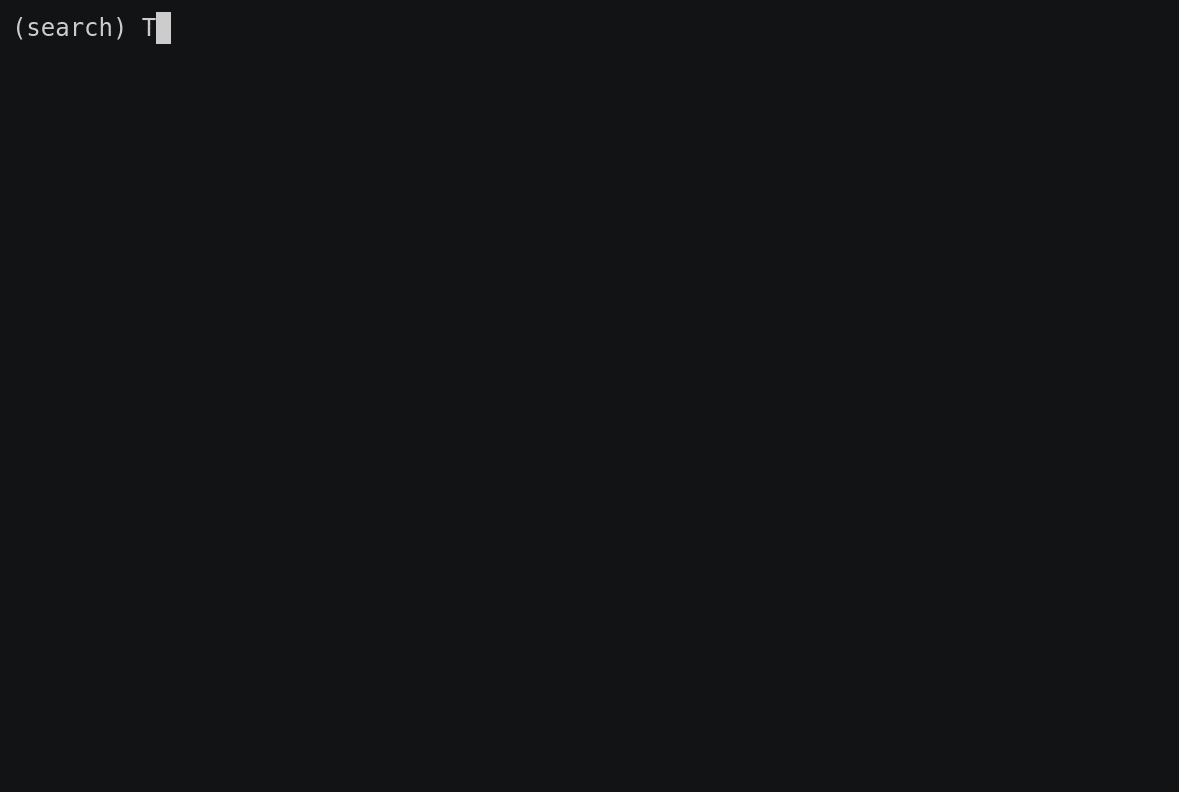

In [26]:
import urllib

from IPython.display import Image

# Get an image
request = urllib.request.urlopen("https://raw.githubusercontent.com/neuml/txtai/master/demo.gif")

# Upsert new record having both text and an object
embeddings.upsert([("txtai", {"text": "txtai executes machine-learning workflows to transform data and build AI-powered semantic search applications.", "object": request.read()}, None)])

# Query txtai for the most similar result to "machine learning" and get associated object
result = embeddings.search("select object from txtai where similar('machine learning') limit 1")[0]["object"]

# Display image
Image(result.getvalue(), width=600)

# Reindex

Now that content is stored, embedding indexes can be rebuilt with different configuration settings.

In [27]:
# Print index info before (info() is also new!)
embeddings.info()

# Reindex
embeddings.reindex({"path": "sentence-transformers/paraphrase-MiniLM-L3-v2"})

print("------")

# Print index info after
embeddings.info()

{
  "backend": "faiss",
  "build": {
    "create": "2022-05-10T20:32:24Z",
    "python": "3.7.13",
    "settings": {
      "components": "IDMap,Flat"
    },
    "system": "Linux (x86_64)",
    "txtai": "4.5.0"
  },
  "content": "sqlite",
  "dimensions": 768,
  "objects": true,
  "offset": 7,
  "path": "sentence-transformers/nli-mpnet-base-v2",
  "update": "2022-05-10T20:32:25Z"
}
------
{
  "backend": "faiss",
  "build": {
    "create": "2022-05-10T20:32:26Z",
    "python": "3.7.13",
    "settings": {
      "components": "IDMap,Flat"
    },
    "system": "Linux (x86_64)",
    "txtai": "4.5.0"
  },
  "content": "sqlite",
  "dimensions": 384,
  "objects": true,
  "offset": 7,
  "path": "sentence-transformers/paraphrase-MiniLM-L3-v2",
  "update": "2022-05-10T20:32:26Z"
}


# Index compression

txtai normally saves index files to a directory. With 4.0, it is now possible to save compressed indexes. Indexes can be compressed to tar.gz, tar.bz2, tar.xz and zip. txtai can load compressed files and treats them as directories.

Compressed indexes can be used as a backup strategy and/or as the primary storage mechanism.

In [28]:
# Save index as tar.xz
embeddings.save("index.tar.xz")
!tar -tvJf index.tar.xz
!echo
!xz -l index.tar.xz
!echo

# Reload index
embeddings.load("index.tar.xz")

# Test search
embeddings.search("lucky guy", 1)

drwx------ root/root         0 2022-05-10 20:32 ./
-rw-r--r-- root/root       301 2022-05-10 20:32 ./config
-rw-r--r-- root/root     77824 2022-05-10 20:32 ./documents
-rw-r--r-- root/root     10898 2022-05-10 20:32 ./embeddings

Strms  Blocks   Compressed Uncompressed  Ratio  Check   Filename
    1       1     45.8 KiB    100.0 KiB  0.458  CRC64   index.tar.xz



[{'id': '4',
  'score': 0.3691234290599823,
  'text': 'Maine man wins $1M from $25 lottery ticket'}]

Note the compression ratio. Depending on the type of data stored, this could be quite substantial (text will compress much better than objects). 

# External vector models

txtai supports generating vectors with [Hugging Face Transformers](https://github.com/huggingface/transformers), [PyTorch](https://github.com/pytorch/pytorch), [ONNX](https://github.com/microsoft/onnxruntime) and [Word Vector](https://github.com/neuml/staticvectors) models.

This release adds support for pre-computed vectors using external models. External models may be an API, custom library and/or another way to vectorize data. This adds flexibility given the high computation cost in building embeddings vectors. Embeddings generation could be outsourced or consolidated to a group of servers with GPUs, leaving index servers to run on lower resourced machines. 

The example below uses the [Hugging Face Inference API](https://huggingface.co/inference-api) to build embeddings vectors. We'll load the [exact model as in the first example](#scrollTo=0p3WCDniUths) and produce the same results.

In [29]:
import numpy as np
import requests

def transform(inputs):
  response = requests.post("https://api-inference.huggingface.co/pipeline/feature-extraction/sentence-transformers/nli-mpnet-base-v2",
                           json={"inputs": inputs})

  return np.array(response.json(), dtype=np.float32)

# Index data using vectors from Inference API
embeddings = Embeddings({"method": "external", "transform": transform, "content": True})
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

# Run an embeddings search for each query
for query in ("feel good story", "climate change", "public health story", "war", "wildlife", "asia", "lucky", "dishonest junk"):
    # Extract text field from result
    text = embeddings.search(f"select id, text, score from txtai where similar('{query}')", 1)[0]["text"]

    # Print text
    print("%-20s %s" % (query, text))

Query                Best Match
--------------------------------------------------
feel good story      Maine man wins $1M from $25 lottery ticket
climate change       Canada's last fully intact ice shelf has suddenly collapsed, forming a Manhattan-sized iceberg
public health story  US tops 5 million confirmed virus cases
war                  Beijing mobilises invasion craft along coast as Taiwan tensions escalate
wildlife             The National Park Service warns against sacrificing slower friends in a bear attack
asia                 Beijing mobilises invasion craft along coast as Taiwan tensions escalate
lucky                Maine man wins $1M from $25 lottery ticket
dishonest junk       Make huge profits without work, earn up to $100,000 a day


The next example uses [spaCy](https://github.com/explosion/spaCy) to build vectors and then loads them into txtai. The vectors with this model are much faster to generate at the expense of accuracy.

In [30]:
%%capture
!pip install spacy --upgrade
!python -m spacy download en_core_web_md

In [31]:
import spacy

# Load spacy
nlp = spacy.load("en_core_web_md")

def transform(inputs):
    return [result.vector for result in nlp.pipe(inputs)]

# Index data with spacy pipeline
embeddings = Embeddings({"method": "external", "transform": transform, "content": True})
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])

# Run search
print(embeddings.search("select id, text, score from txtai where similar('nature')", 1))

[{'id': '3', 'text': 'The National Park Service warns against sacrificing slower friends in a bear attack', 'score': 0.44850602746009827}]


# Wrapping up

This notebook gave a quick overview of txtai. txtai 4.0 is now out!

See the following links for more information.

- [4.0 Release on GitHub](https://github.com/neuml/txtai/releases/tag/v4.0.0)
- [Documentation site](https://neuml.github.io/txtai)
- [Full list of examples](https://neuml.github.io/txtai/examples/)